In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_style("darkgrid")

In [2]:
data = pd.read_csv("./Dataset/household_power_consumption.txt", sep=";")

C:\Users\nitis\AppData\Local\Temp\ipykernel_22964\1837839935.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./Dataset/household_power_consumption.txt", sep=";")


In [3]:
# convert to datetime
data["datetime"] = data["Date"] + " " + data["Time"]
data["datetime"] = pd.to_datetime(data["datetime"], dayfirst=True)

In [4]:
#set datetime as index

data.drop(columns=["Date", "Time"], inplace=True)
data.set_index("datetime", inplace=True)


In [5]:
# replace ? and convert each col to float and fillnas

for col in data.columns:
    data[col].replace("?", np.nan, inplace=True)
    data[col] = data[col].astype(np.float32)

data.ffill( axis=0, inplace=True)

In [6]:
# concatenate by hour using index

data_resampled = data.resample("H").sum()
data_resampled["hour"] = data_resampled.index.hour
data_resampled.index = data_resampled.index.date


In [ ]:
# plot energy usage

data_resampled.pivot(columns='hour', values="Global_active_power").dropna().T.plot(figsize=(12, 6), alpha=0.02, color="blue", legend=False)

In [11]:
# only get power and hour data 
data_pivot = data_resampled.pivot(columns="hour", values="Global_active_power").dropna()
train_x = data_pivot.values


c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\sea

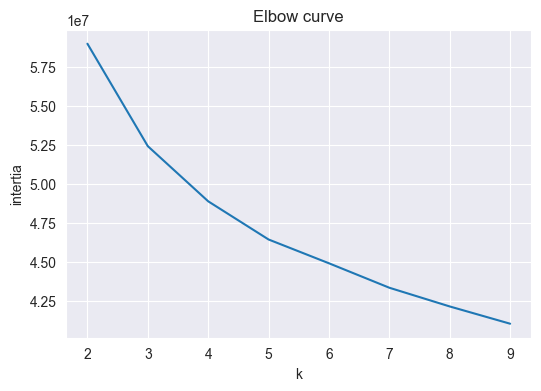

In [41]:
# elbow curve to get estimated profiles 

km_models = [KMeans(n_clusters=k, n_init="auto", random_state=42).fit(train_x) for k in range(2, 10)]
k_inertias = [model.inertia_ for model in km_models]

plt.figure(figsize=(6, 4))
sns.lineplot(x=range(2,10,1), y=k_inertias)
plt.title("Elbow curve")
plt.xlabel("k")
plt.ylabel("intertia")
plt.xticks(range(2, 10, 1));

c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\sea

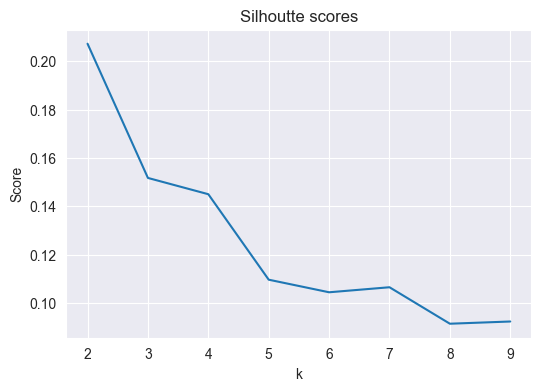

In [47]:
# silhoutte diagram to get estimated profiles

k_silhouttes = [silhouette_score(train_x, model.labels_) for model in km_models]

plt.figure(figsize=(6,4))
sns.lineplot(x=range(2,10,1), y=k_silhouttes)
plt.title("Silhoutte scores")
plt.xlabel("k")
plt.ylabel("Score")
plt.xticks(range(2,10,1));


In [48]:
# use k=2
kmeans = KMeans(n_clusters=2, n_init="auto")
clusters = kmeans.fit_predict(train_x)
clusters_sr = pd.Series(clusters, name="cluster")


In [54]:
cluster_df = data_pivot.set_index(clusters_sr, append=True)

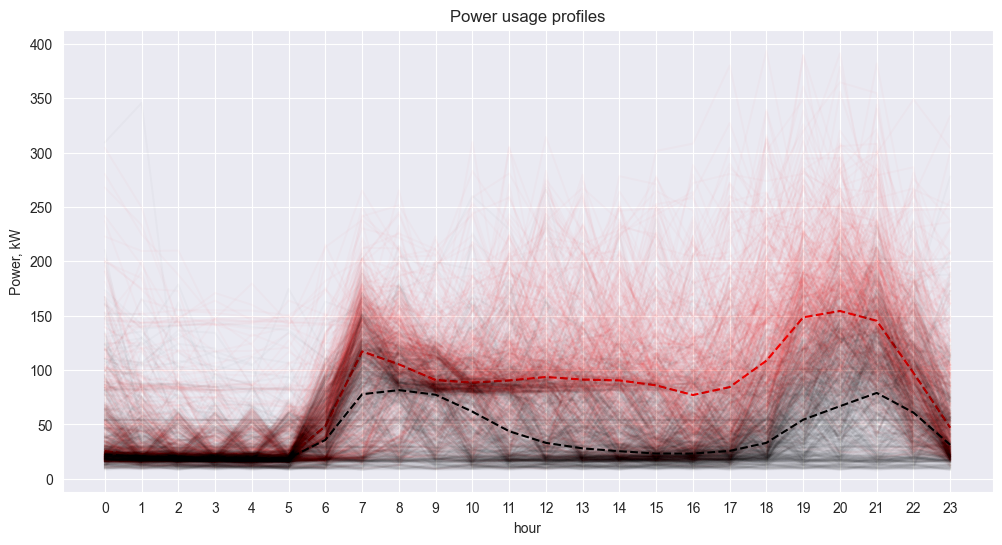

In [99]:
color = ["red", "black"]
cluster_labels = cluster_df.index.get_level_values(1).unique()

fig, ax = plt.subplots(figsize=(12, 6))
for cluster, color in zip(cluster_labels, color):

    cluster_df.xs(cluster, level=1).T.plot(alpha=0.02, color=color, legend=False, ax=ax)
    cluster_df.xs(cluster, level=1).T.median(axis=1).plot(color=color, ls="--", legend=False, ax=ax)

plt.ylabel("Power, kW")
plt.title("Power usage profiles")
plt.xticks(range(0, 24, 1));
    


